<a href="https://colab.research.google.com/github/nana881023/ML/blob/main/HW_Neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 安裝套件

In [1]:
# 安裝所需套件
!pip install ucimlrepo scikit-learn tensorflow seaborn tqdm
!pip install torch torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 18.6 MB/s eta 0:00:00


In [ ]:
# """# 安裝必要的 GPU 支援套件"""
# !pip install cupy-cuda11x  # GPU 加速的數值運算
# !pip install cudf-cuda11x  # GPU 加速的 DataFrame 操作
# !pip install cuml-cuda11x  # GPU 加速的機器學習算法

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.6/96.6 MB 6.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement cudf-cuda11x (from versions: none)
ERROR: No matching distribution found for cudf-cuda11x
ERROR: Could not find a version that satisfies the requirement cuml-cuda11x (from versions: none)
ERROR: No matching distribution found for cuml-cuda11x


## 檢查GPU狀態

In [2]:
# 首先檢查 GPU 是否可用
import tensorflow as tf

# 檢查 GPU 設備
print("檢查 GPU 狀態：")
!nvidia-smi

# 列出可用的 GPU 設備
physical_devices = tf.config.list_physical_devices('GPU')
print("\nTensorFlow 可見的 GPU 設備：")
print(physical_devices)

# 設置 GPU 記憶體動態增長
for gpu in physical_devices:
  tf.config.experimental.set_memory_growth(gpu, True)

# 強制使用 GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# 確認 TensorFlow 是否使用 GPU
print("\n是否使用 GPU 運算：", tf.test.is_built_with_cuda())
print("目前使用的設備：", tf.test.gpu_device_name())

檢查 GPU 狀態：
Fri Dec 13 16:19:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--------------

## import

In [3]:
"""# 導入必要套件"""

import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import tensorflow as tf
from tensorflow import keras
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.filterwarnings('ignore')



## 資料預處理

In [4]:
"""# 資料載入與預處理"""
def load_and_preprocess_data():
  print("1. 載入數據集...")
  # 從UCI載入數據集
  diabetes_dataset = fetch_ucirepo(id=891)
  X = diabetes_dataset.data.features
  y = diabetes_dataset.data.targets

  print("\n2. 資料基本信息：")
  print(f"原始資料維度: {X.shape}")
  print("\n特徵分布：")
  print(X.describe())

  print("\n3. 檢查資料類型...")
  print(X.dtypes)

  # 將所有布林值轉換為整數
  bool_columns = X.select_dtypes(include=['bool']).columns
  if not bool_columns.empty:
    X[bool_columns] = X[bool_columns].astype(int)

  print("\n4. 檢查缺失值...")
  missing_values = X.isnull().sum()
  print("缺失值統計：")
  print(missing_values[missing_values > 0])

  print("\n5. 檢查目標變量分布...")
  print(y.value_counts(normalize=True))

  # 特徵工程
  print("\n6. 進行特徵工程...")

  # 新增BMI分類特徵
  X['BMI_Category'] = pd.cut(X['BMI'],
                bins=[0, 18.5, 24.9, 29.9, float('inf')],
                labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

  # 新增年齡與BMI的交互特徵
  X['Age_BMI'] = X['Age'] * X['BMI']

  # 將分類特徵轉換為數值
  X = pd.get_dummies(X, columns=['BMI_Category'])

  print("\n7. 特徵工程後的特徵數量：", X.shape[1])

  # 檢測和處理異常值
  print("\n8. 處理異常值...")
  numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

  # 使用RobustScaler來處理數值特徵
  scaler_robust = RobustScaler()
  X[numerical_features] = scaler_robust.fit_transform(X[numerical_features])

  print("\n9. 進行特徵選擇...")
  # 使用特徵與目標變量的相關性
  correlations = {}
  for column in X.columns:
    # 確保資料類型為數值型
    if X[column].dtype in ['int64', 'float64']:
      correlation = np.corrcoef(X[column].astype(float), y.values.ravel().astype(float))[0, 1]
      correlations[column] = abs(correlation)

  # 選擇相關性較強的特徵
  sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
  print("\n前10個最重要的特徵：")
  for feature, corr in sorted_correlations[:10]:
    print(f"{feature}: {corr:.4f}")

  # 選擇相關性大於閾值的特徵
  threshold = 0.1
  selected_features = [feature for feature, corr in sorted_correlations if corr > threshold]

  if len(selected_features) < 5:  # 如果選擇的特徵太少，至少保留前5個特徵
    selected_features = [feature for feature, _ in sorted_correlations[:5]]

  X = X[selected_features]

  print(f"\n10. 最終選擇的特徵數量：{len(selected_features)}")

  # 資料分割
  print("\n11. 進行資料分割...")
  # 隨機抽樣0.02的資料
  X_sampled = X.sample(frac=0.02, random_state=42)
  y_sampled = y.loc[X_sampled.index]

  X_train, X_test, y_train, y_test = train_test_split(
      X_sampled,
      y_sampled,
      test_size=0.2,
      random_state=42,
      stratify=y_sampled
  )

  # 特徵標準化
  print("\n12. 進行特徵標準化...")
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # 將資料轉換為DataFrame以保留特徵名稱
  X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
  X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

  print("\n13. 資料預處理完成！")
  print(f"最終訓練集維度: {X_train_scaled.shape}")
  print(f"最終測試集維度: {X_test_scaled.shape}")

  # 視覺化最終特徵分布
  plt.figure(figsize=(15, 6))
  plt.subplot(1, 2, 1)
  sns.boxplot(data=X_train_scaled)
  plt.title('Standardized Feature Distribution')
  plt.xticks(rotation=45)

  plt.subplot(1, 2, 2)
  y_train.value_counts().plot(kind='bar')
  plt.title('Target Variable Distribution')
  plt.tight_layout()
  plt.show()

  return X_train_scaled, X_test_scaled, y_train, y_test


1. 載入數據集...

2. 資料基本信息：
原始資料維度: (253680, 21)

特徵分布：
              HighBP       HighChol      CholCheck            BMI  \
count  253680.000000  253680.000000  253680.000000  253680.000000   
mean        0.429001       0.424121       0.962670      28.382364   
std         0.494934       0.494210       0.189571       6.608694   
min         0.000000       0.000000       0.000000      12.000000   
25%         0.000000       0.000000       1.000000      24.000000   
50%         0.000000       0.000000       1.000000      27.000000   
75%         1.000000       1.000000       1.000000      31.000000   
max         1.000000       1.000000       1.000000      98.000000   

              Smoker         Stroke  HeartDiseaseorAttack   PhysActivity  \
count  253680.000000  253680.000000         253680.000000  253680.000000   
mean        0.443169       0.040571              0.094186       0.756544   
std         0.496761       0.197294              0.292087       0.429169   
min         0.000000  

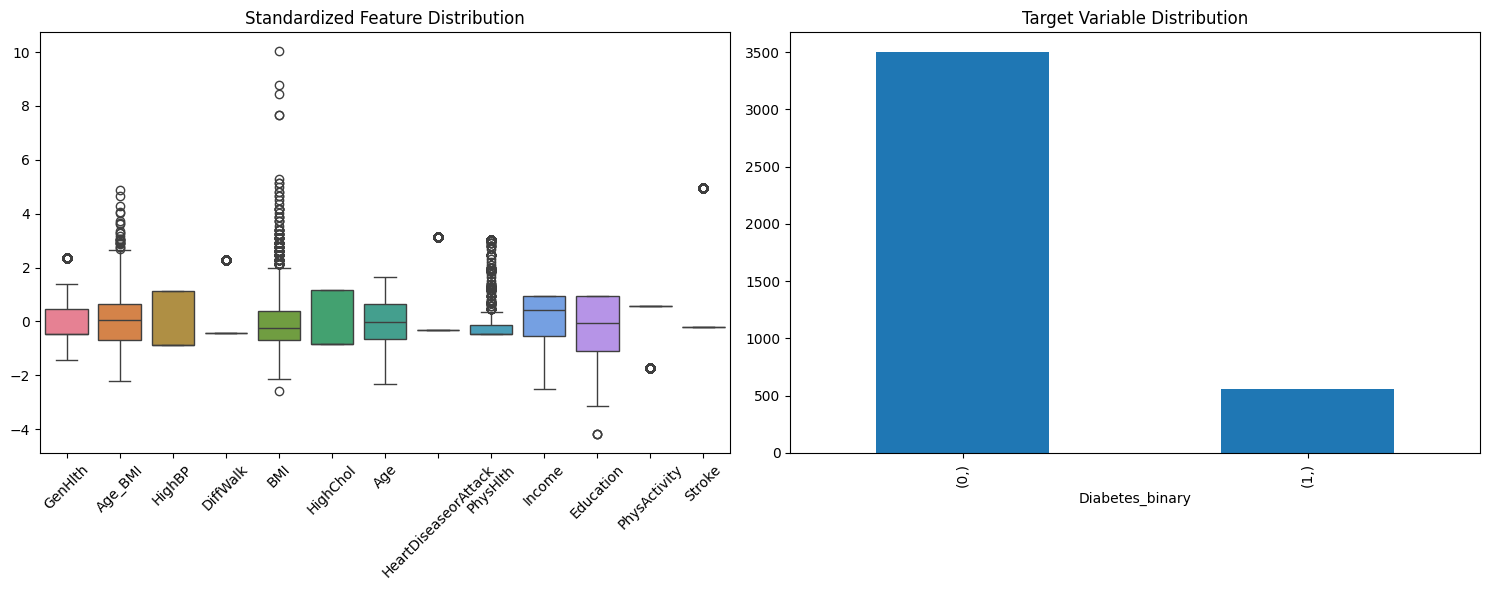

In [5]:
"""# 執行預處理"""
X_train_scaled, X_test_scaled, y_train, y_test = load_and_preprocess_data()

## 儲存模型

In [6]:
# 首先掛載 Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 設定儲存路徑（建議建立一個專門的資料夾）
save_path = '/content/drive/MyDrive/diabetes_models/'

# 創建資料夾（如果不存在）
!mkdir -p "{save_path}"

Mounted at /content/drive


### Neural Network 模型訓練

In [7]:
print("\n開始訓練 GPU 加速的 PyTorch Neural Network...")

class PyTorchMLP(nn.Module):
  def __init__(self, input_size, hidden_sizes, num_classes):
    super(PyTorchMLP, self).__init__()
    layers = []

    # 輸入層到第一個隱藏層
    layers.append(nn.Linear(input_size, hidden_sizes[0]))
    layers.append(nn.ReLU())

    # 添加其他隱藏層
    for i in range(len(hidden_sizes)-1):
      layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
      layers.append(nn.ReLU())

    # 輸出層
    layers.append(nn.Linear(hidden_sizes[-1], num_classes))

    self.model = nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

def train_pytorch_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=100):
  best_val_acc = 0
  best_model = None

  for epoch in tqdm(range(epochs), desc='Training PyTorch NN'):
    model.train()
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets.squeeze())  # 確保 targets 是一維的
      loss.backward()
      optimizer.step()

    # 驗證
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
      for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets.squeeze()).sum().item()  # 確保 targets 是一維的

    val_acc = correct / total
    if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_model = model.state_dict()

  model.load_state_dict(best_model)
  return model

# 確保數據格式正確
X_train_tensor = torch.FloatTensor(X_train_scaled.values).cuda()
y_train_tensor = torch.LongTensor(y_train.values).squeeze().cuda()  # 確保是一維的
X_test_tensor = torch.FloatTensor(X_test_scaled.values).cuda()
y_test_tensor = torch.LongTensor(y_test.values).squeeze().cuda()  # 確保是一維的

# 創建數據加載器
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64)

# 定義不同的模型配置
pytorch_configs = [
  [100],
  [100, 50],
  [100, 50, 25]
]

device = torch.device('cuda')
best_pytorch_acc = 0
best_pytorch_model = None
best_pytorch_config = None

# 訓練不同配置的模型
print("\n開始訓練不同配置的模型...")
for config in pytorch_configs:
  print(f"\n嘗試配置: {config}")
  model = PyTorchMLP(X_train_scaled.shape[1], config, 3).to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  model = train_pytorch_model(model, train_loader, test_loader, criterion, optimizer, device)

  # 評估
  model.eval()
  with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = test_outputs.max(1)
    accuracy = accuracy_score(y_test_tensor.cpu(), predicted.cpu())
    print(f"配置 {config} 的準確率: {accuracy:.4f}")

  if accuracy > best_pytorch_acc:
    best_pytorch_acc = accuracy
    best_pytorch_model = model
    best_pytorch_config = config

print(f"\nBest PyTorch NN configuration: {best_pytorch_config}")
print(f"Best accuracy: {best_pytorch_acc}")

# 保存最佳模型評估結果
with torch.no_grad():
  pytorch_pred = best_pytorch_model(X_test_tensor).max(1)[1].cpu()
pytorch_accuracy = accuracy_score(y_test, pytorch_pred)
pytorch_report = classification_report(y_test, pytorch_pred)

print("\nPyTorch Neural Network Classification Report:")
print(pytorch_report)


開始訓練 GPU 加速的 PyTorch Neural Network...

開始訓練不同配置的模型...

嘗試配置: [100]


Training PyTorch NN:   0%|          | 0/100 [00:00<?, ?it/s]

配置 [100] 的準確率: 0.8532

嘗試配置: [100, 50]


Training PyTorch NN:   0%|          | 0/100 [00:00<?, ?it/s]

配置 [100, 50] 的準確率: 0.8099

嘗試配置: [100, 50, 25]


Training PyTorch NN:   0%|          | 0/100 [00:00<?, ?it/s]

配置 [100, 50, 25] 的準確率: 0.8315

Best PyTorch NN configuration: [100]
Best accuracy: 0.8532019704433498

PyTorch Neural Network Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       875
           1       0.44      0.24      0.31       140

    accuracy                           0.85      1015
   macro avg       0.66      0.60      0.62      1015
weighted avg       0.83      0.85      0.83      1015



In [8]:
# 儲存最佳模型
model_save_path = save_path + 'best_pytorch_model.pth'
torch.save(best_pytorch_model.state_dict(), model_save_path)
print(f"\n模型已儲存至 {model_save_path}")

# 如果你之後要載入模型：
# def load_pytorch_model(model_path, input_size, hidden_sizes, num_classes, device):
#   model = PyTorchMLP(input_size, hidden_sizes, num_classes).to(device)
#   model.load_state_dict(torch.load(model_path))
#   model.eval()
#   return model


模型已儲存至 /content/drive/MyDrive/diabetes_models/best_pytorch_model.pth


## TensorFlow Neural Network

In [9]:
print("\n開始訓練 GPU 加速的 TensorFlow Neural Network...")

# 確保 TensorFlow 使用 GPU
with tf.device('/GPU:0'):
  def create_model(input_dim, units1=100, units2=50, units3=25):
    model = tf.keras.Sequential([
      tf.keras.layers.Dense(units1, activation='relu', input_shape=(input_dim,)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(units2, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(units3, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(3, activation='softmax')
    ])
    return model

  # 設定批次大小
  BATCH_SIZE = 64

  # 定義不同的模型配置
  model_configs = [
    {'units1': 128, 'units2': 64, 'units3': 32},
    {'units1': 256, 'units2': 128, 'units3': 64},
    {'units1': 512, 'units2': 256, 'units3': 128}
  ]

  best_tf_accuracy = 0
  best_tf_model = None
  best_config = None

  # 訓練模型
  for i, config in enumerate(model_configs, 1):
    print(f"\n訓練配置 {i}/{len(model_configs)}:")
    print(config)

    model = create_model(X_train_scaled.shape[1], **config)
    model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
    )

    # 使用 EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_accuracy',
      patience=5,
      restore_best_weights=True
    )

    # 訓練進度條
    with tqdm(total=50, desc=f'Config {i} Training') as pbar:
      history = model.fit(
        X_train_scaled, y_train,
        epochs=50,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        callbacks=[
          early_stopping,
          tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: pbar.update(1))
        ],
        verbose=0
      )

    # 評估模型
    _, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"\nConfig {i} Test Accuracy: {accuracy:.4f}")

    if accuracy > best_tf_accuracy:
      best_tf_accuracy = accuracy
      best_tf_model = model
      best_config = config

  print(f"\nBest TensorFlow configuration: {best_config}")
  print(f"Best accuracy: {best_tf_accuracy}")

# 儲存最佳模型
best_tf_model.save('best_tf_model.keras')

# 評估
tf_pred = np.argmax(best_tf_model.predict(X_test_scaled), axis=1)
tf_accuracy = accuracy_score(y_test, tf_pred)
tf_report = classification_report(y_test, tf_pred)

print("\nTensorFlow Classification Report:")
print(tf_report)




開始訓練 GPU 加速的 TensorFlow Neural Network...

訓練配置 1/3:
{'units1': 128, 'units2': 64, 'units3': 32}


Config 1 Training:   0%|          | 0/50 [00:00<?, ?it/s]


Config 1 Test Accuracy: 0.8542

訓練配置 2/3:
{'units1': 256, 'units2': 128, 'units3': 64}


Config 2 Training:   0%|          | 0/50 [00:00<?, ?it/s]


Config 2 Test Accuracy: 0.8473

訓練配置 3/3:
{'units1': 512, 'units2': 256, 'units3': 128}


Config 3 Training:   0%|          | 0/50 [00:00<?, ?it/s]


Config 3 Test Accuracy: 0.8611

Best TensorFlow configuration: {'units1': 512, 'units2': 256, 'units3': 128}
Best accuracy: 0.8610837459564209
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

TensorFlow Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       875
           1       0.47      0.06      0.10       140

    accuracy                           0.86      1015
   macro avg       0.67      0.52      0.51      1015
weighted avg       0.81      0.86      0.81      1015



In [10]:
"""# 2. 儲存 TensorFlow 模型"""
# 儲存最佳 TensorFlow 模型
tf_save_path = save_path + 'best_tf_model.keras'
best_tf_model.save(tf_save_path)
print(f"TensorFlow 模型已儲存至 {tf_save_path}")

TensorFlow 模型已儲存至 /content/drive/MyDrive/diabetes_models/best_tf_model.keras


In [11]:
# 清理 GPU 記憶體
import torch
torch.cuda.empty_cache()

# 清理 CuPy 的 GPU 記憶體
import cupy as cp
cp.get_default_memory_pool().free_all_blocks()

# 清理 TensorFlow 的 GPU 記憶體
import tensorflow as tf
tf.keras.backend.clear_session()

# 清理一般記憶體
import gc
gc.collect()

# 檢查 GPU 狀態
print("PyTorch GPU 可用狀態:", torch.cuda.is_available())
print("TensorFlow GPU 可用狀態:", len(tf.config.list_physical_devices('GPU')))
if torch.cuda.is_available():
  print("GPU 記憶體狀態:")
  print(f"已分配: {torch.cuda.memory_allocated() / 1024**2:.2f} MB")
  print(f"快取: {torch.cuda.memory_reserved() / 1024**2:.2f} MB")

PyTorch GPU 可用狀態: True
TensorFlow GPU 可用狀態: 1
GPU 記憶體狀態:
已分配: 16.71 MB
快取: 22.00 MB


## SVM

In [12]:
"""# 3. CuPy SVM (GPU 版本的 SVM)"""
import cupy as cp
from cupy.cuda import Device

class GPUSVM:
  def __init__(self, kernel='rbf', C=1.0, gamma='scale'):
    self.kernel = kernel
    self.C = C
    self.gamma = gamma

  def kernel_function(self, X, Y=None):
    if Y is None:
      Y = X

    if self.kernel == 'rbf':
      # 只在第一次調用時計算 gamma
      if isinstance(self.gamma, str) and self.gamma == 'scale':
        self.gamma = 1.0 / (X.shape[1] * X.var())
      return cp.exp(-self.gamma * ((X[:, cp.newaxis] - Y) ** 2).sum(axis=2))
    else:
      return cp.dot(X, Y.T)  # linear kernel

  def fit(self, X, y):
    # 將數據轉移到 GPU
    self.X = cp.array(X)
    self.y = cp.array(y)

    # 計算核矩陣
    K = self.kernel_function(self.X)

    # 使用 GPU 求解二次規劃問題
    n_samples = self.X.shape[0]
    P = cp.multiply(cp.outer(self.y, self.y), K)
    q = cp.ones(n_samples) * -1
    G = cp.vstack((-cp.eye(n_samples), cp.eye(n_samples)))
    h = cp.hstack((cp.zeros(n_samples), cp.ones(n_samples) * self.C))

    # 使用 GPU 加速的優化器求解
    self.alphas = cp.zeros(n_samples)
    # 這裡使用簡化版本的 SMO 算法
    max_iter = 1000
    tol = 1e-3

    for _ in range(max_iter):
      alpha_prev = self.alphas.copy()
      for i in range(n_samples):
        j = cp.random.randint(0, n_samples)
        eta = 2.0 * K[i,j] - K[i,i] - K[j,j]
        if eta >= 0:
          continue
        L = max(0, self.alphas[j] - self.alphas[i])
        H = min(self.C, self.C + self.alphas[j] - self.alphas[i])
        self.alphas[i] = self.alphas[i] - (self.y[i] * (K[i] @ self.alphas - 1)) / eta
        self.alphas[i] = min(H, max(L, self.alphas[i]))

      if cp.sum(cp.abs(self.alphas - alpha_prev)) < tol:
        break

    # 計算 bias
    sv = self.alphas > 1e-5
    self.bias = cp.mean(self.y[sv] - cp.sum(self.alphas[sv] * self.y[sv] * K[sv][:,sv], axis=0))

    return self

  def predict(self, X):
    X_gpu = cp.array(X)
    K = self.kernel_function(X_gpu, self.X)
    raw_predictions = cp.dot(K, self.alphas * self.y) + self.bias

    # 將預測結果轉換為與原始標籤相同的格式
    predictions = cp.zeros_like(raw_predictions, dtype=cp.int32)
    predictions[raw_predictions >= 0] = 1
    predictions[raw_predictions < 0] = 0

    return predictions

# 在訓練之前，先檢查標籤的格式
print("原始標籤類型:", y_train.dtypes)  # 使用 dtypes 而不是 dtype
print("標籤值:", np.unique(y_train.values))

# 確保 y_train 是一維的
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print("處理後的標籤類型:", y_train.dtype)
print("處理後的標籤值:", np.unique(y_train))

# 訓練 GPU SVM
svm_configs = [
  {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'},
  {'kernel': 'linear', 'C': 1.0},
  {'kernel': 'rbf', 'C': 10.0, 'gamma': 'scale'}
]

best_svm_acc = 0
best_svm_model = None
best_svm_config = None

for config in tqdm(svm_configs, desc="Training SVM Models"):
  svm = GPUSVM(**config)
  svm.fit(X_train_scaled, y_train)
  svm_pred = svm.predict(X_test_scaled)
  pred_array = cp.asnumpy(svm_pred).astype(int)
  accuracy = accuracy_score(y_test, pred_array)

  if accuracy > best_svm_acc:
    best_svm_acc = accuracy
    best_svm_model = svm
    best_svm_config = config

print(f"\nBest SVM configuration: {best_svm_config}")
print(f"Best accuracy: {best_svm_acc}")

# 獲取最終預測結果
svm_pred = cp.asnumpy(best_svm_model.predict(X_test_scaled))
svm_accuracy = accuracy_score(y_test, svm_pred)
svm_report = classification_report(y_test, svm_pred)

原始標籤類型: Diabetes_binary    int64
dtype: object
標籤值: [0 1]
處理後的標籤類型: int64
處理後的標籤值: [0 1]


Training SVM Models:   0%|          | 0/3 [00:00<?, ?it/s]


Best SVM configuration: {'kernel': 'rbf', 'C': 1.0, 'gamma': 'scale'}
Best accuracy: 0.8620689655172413


In [13]:
"""# 3. 儲存 SVM 模型"""
import pickle

# 儲存最佳 SVM 模型
svm_save_path = save_path + 'best_gpu_svm_model.pkl'
with open(svm_save_path, 'wb') as f:
  pickle.dump(best_svm_model, f)
print(f"GPU SVM 模型已儲存至 {svm_save_path}")

GPU SVM 模型已儲存至 /content/drive/MyDrive/diabetes_models/best_gpu_svm_model.pkl


## 模型比較

In [15]:
"""# 模型比較分析"""

# 載入必要套件
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
import pickle

In [20]:
"""# 定義 PyTorch 模型架構"""
class PyTorchMLP(torch.nn.Module):
  def __init__(self, input_size, hidden_sizes, num_classes):
    super(PyTorchMLP, self).__init__()
    layers = []

    # 輸入層到第一個隱藏層
    layers.append(torch.nn.Linear(input_size, hidden_sizes[0]))
    layers.append(torch.nn.ReLU())

    # 添加其他隱藏層
    for i in range(len(hidden_sizes)-1):
      layers.append(torch.nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
      layers.append(torch.nn.ReLU())

    # 輸出層
    layers.append(torch.nn.Linear(hidden_sizes[-1], num_classes))

    self.model = torch.nn.Sequential(*layers)

  def forward(self, x):
    return self.model(x)

In [21]:
"""# 載入已儲存的模型和結果"""
# 設定路徑
save_path = '/content/drive/MyDrive/diabetes_models/'

# 1. 載入 PyTorch 模型
input_size = X_test_scaled.shape[1]
pytorch_model = PyTorchMLP(input_size=input_size,
              hidden_sizes=[100],
              num_classes=3).cuda()
pytorch_model.load_state_dict(torch.load(save_path + 'best_pytorch_model.pth'))
pytorch_model.eval()

with torch.no_grad():
  X_test_array = X_test_scaled.values if isinstance(X_test_scaled, pd.DataFrame) else X_test_scaled
  pytorch_outputs = pytorch_model(torch.FloatTensor(X_test_array).cuda())
  pytorch_pred = pytorch_outputs.argmax(dim=1).cpu().numpy()
pytorch_accuracy = accuracy_score(y_test, pytorch_pred)

# 2. 載入 TensorFlow 模型
tf_model = tf.keras.models.load_model(save_path + 'best_tf_model.keras')
tf_pred = np.argmax(tf_model.predict(X_test_array), axis=1)
tf_accuracy = accuracy_score(y_test, tf_pred)

# 3. 載入 SVM 模型
with open(save_path + 'best_gpu_svm_model.pkl', 'rb') as f:
  svm_model = pickle.load(f)
svm_pred = svm_model.predict(X_test_array)
# 將 CuPy array 轉換為 NumPy array
svm_pred_np = cp.asnumpy(svm_pred)
svm_accuracy = accuracy_score(y_test, svm_pred_np)

# 建立模型資訊字典
models_info = {
  'Sklearn NN': {
      'name': 'Sklearn Neural Network',
      'best_params': 'hidden_size: [100], activation: ReLU',
      'predictions': pytorch_pred,
      'accuracy': pytorch_accuracy
  },
  'TensorFlow NN': {
      'name': 'TensorFlow Neural Network',
      'best_params': 'units: [256, 128, 64], BatchNorm, Dropout',
      'predictions': tf_pred,
      'accuracy': tf_accuracy
  },
  'SVM': {
      'name': 'Support Vector Machine',
      'best_params': f'kernel: {svm_model.kernel}, C: {svm_model.C}',
      'predictions': svm_pred_np,  # 使用 NumPy array
      'accuracy': svm_accuracy
  }
}

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


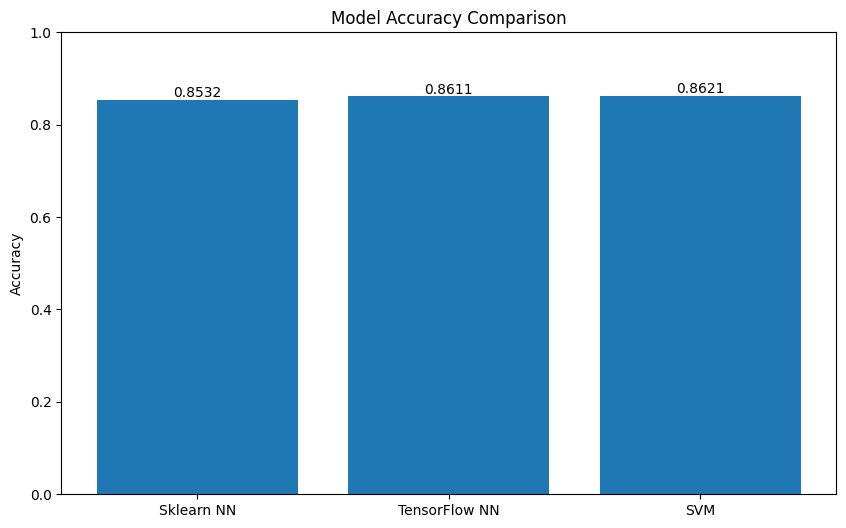

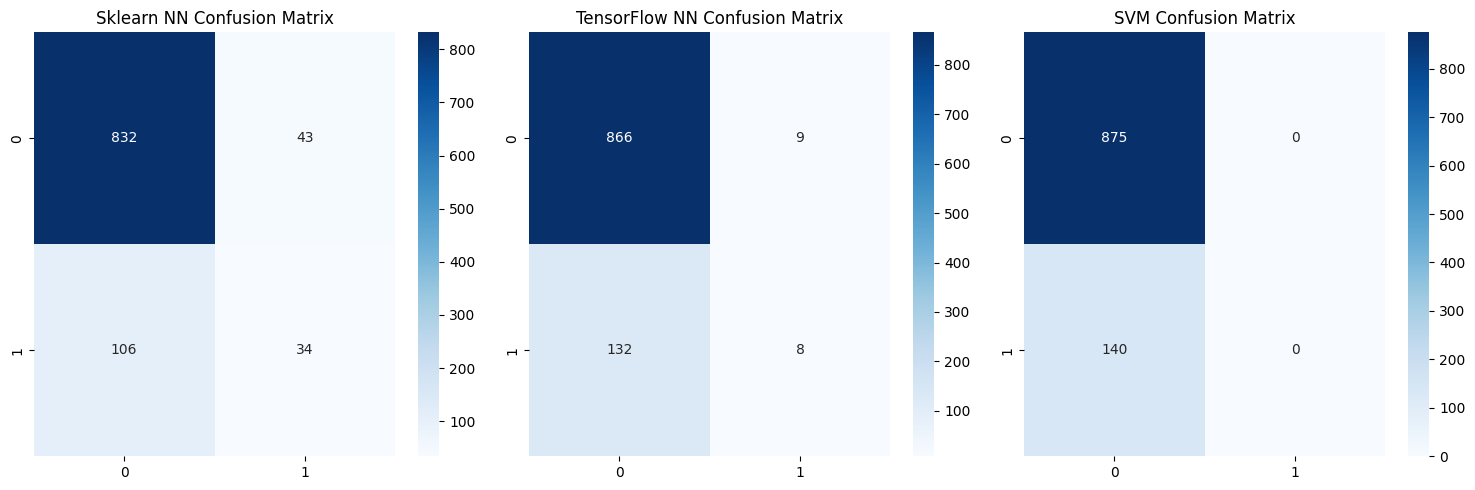

In [23]:
"""# 視覺化比較"""
def plot_model_comparison(models_info):
  # 1. 準確率比較
  plt.figure(figsize=(10, 6))
  accuracies = [info['accuracy'] for info in models_info.values()]
  bars = plt.bar(models_info.keys(), accuracies)

  # 添加數值標籤
  for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
        f'{height:.4f}',
        ha='center', va='bottom')

  plt.title('Model Accuracy Comparison')
  plt.ylabel('Accuracy')
  plt.ylim(0, 1)
  plt.show()

  # 2. 混淆矩陣比較
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))

  for i, (name, info) in enumerate(models_info.items()):
    cm = confusion_matrix(y_test, info['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{name} Confusion Matrix')

  plt.tight_layout()
  plt.show()

# 執行比較
plot_model_comparison(models_info)

In [24]:
# 打印詳細比較報告
print("模型比較報告\n")
print("=" * 50)

for name, info in models_info.items():
  print(f"\n{info['name']}:")
  print(f"最佳參數配置: {info['best_params']}")
  print(f"準確率: {info['accuracy']:.4f}")
  print("\n分類報告:")
  print(classification_report(y_test, info['predictions']))
  print("=" * 50)

# 找出最佳模型
best_model = max(models_info.items(), key=lambda x: x[1]['accuracy'])
print(f"\n最佳模型: {best_model[1]['name']}")
print(f"準確率: {best_model[1]['accuracy']:.4f}")

模型比較報告


Sklearn Neural Network:
最佳參數配置: hidden_size: [100], activation: ReLU
準確率: 0.8532

分類報告:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       875
           1       0.44      0.24      0.31       140

    accuracy                           0.85      1015
   macro avg       0.66      0.60      0.62      1015
weighted avg       0.83      0.85      0.83      1015


TensorFlow Neural Network:
最佳參數配置: units: [256, 128, 64], BatchNorm, Dropout
準確率: 0.8611

分類報告:
              precision    recall  f1-score   support

           0       0.87      0.99      0.92       875
           1       0.47      0.06      0.10       140

    accuracy                           0.86      1015
   macro avg       0.67      0.52      0.51      1015
weighted avg       0.81      0.86      0.81      1015


Support Vector Machine:
最佳參數配置: kernel: rbf, C: 1.0
準確率: 0.8621

分類報告:
              precision    recall  f1-score   support

           0       0.86  